In [1]:
#  Required imports

print("Importing standard library")
import os, sys, time

print("Importing python data libraries")
import numpy as np
from   matplotlib import pyplot as plt, colors

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.data_preparation import DataTable
from backends.density_model    import DensityModel, get_sum_gauss_density
from backends.plot             import plot_data, plot_ratio, plot_pull, get_ratio_1D
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename

from backends import plot as plot, density_model as density_model


Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends


In [2]:
#  Inputs config

input_fname = "../Data/SM_QCD_2M_rivet_output.pickle"


In [3]:
#  Model config

output_size_per_stage     = 20
max_epochs                = 1000
batch_size                = 5000
epoch_increase_per_level  = 0
early_stopping_patience   = 10
early_stopping_min_delta  = 0
validation_split          = 0.5

load_whitening_funcs = ".whitening_funcs.pickle"

load_model_dir = None                        # ".QCD_density_model"
save_model_dir = ".QCD_density_model_2M"     # ".QCD_density_model"

learning_rate = 0.001      # 0.01 for SGD or 0.001 otherwise
optimiser     = "adam"     # SGD, Adam or AdaDelta

In [4]:
#  Data config

observable_limits = {}
observable_limits ["m_ll"      ] = [75    , 105  ]
observable_limits ["pT_ll"     ] = [0     , 900  ]
observable_limits ["theta_ll"  ] = [0     , np.pi]
observable_limits ["rap_ll"    ] = [0     , 2.2  ]
observable_limits ["m_jj"      ] = [150   , 5000 ]
observable_limits ["pT_jj"     ] = [0     , 900  ]
observable_limits ["theta_jj"  ] = [0     , np.pi]
observable_limits ["rap_jj"    ] = [0     , 4.4  ]
observable_limits ["pT_j1"     ] = [40    , 1200 ]
observable_limits ["pT_j2"     ] = [35    , 1200 ]
observable_limits ["Dy_j_j"    ] = [0     , 8.8  ]
observable_limits ["Dphi_j_j"  ] = [-np.pi, np.pi]
observable_limits ["N_jets"    ] = [2     , 5    ]
observable_limits ["N_gap_jets"] = [0     , 2    ]

remove_observables = ["N_jets", "pT_ll", "rap_ll", "theta_ll", "pT_jj", "theta_jj", "rap_jj", "pT_j1", "pT_j2", "N_gap_jets"]

int_observables = ["N_jets", "N_gap_jets"]

observables_order = ["m_jj", "m_ll", "Dphi_j_j", "Dy_j_j"]

plot.observable_limits = observable_limits
plot.int_observables   = int_observables

num_observables = len(observables_order)


In [5]:
#  Load and format the data
#

print(f"Creating QCD data table")
print(f" -- events from file {input_fname}")
data = DataTable(input_fname)
print(f" -- Table created with {data.get_num_events()} events")
for observable, limits in observable_limits.items() :
    print(f" -- filtering observable {observable} between {limits[0]} and {limits[1]}")
    data.filter(observable, limits[0], limits[1])
    print(f" -- {data.get_num_events()} events survived")
for observable in remove_observables :
    print(f" -- removing observable {observable}")
    data.remove_column(observable)
print(" -- ordering observables")
data.reorder(*observables_order)
data.print_summary()
    

Creating QCD data table
 -- events from file ../Data/SM_QCD_2M_rivet_output.pickle
 -- Table created with 2000000 events
 -- filtering observable m_ll between 75 and 105
 -- 1269318 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 1269300 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 1269300 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 1241601 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 1206816 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 1206816 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 1206816 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 1206816 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 1206749 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 1206181 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 1206181 event

In [6]:

#  Load whitening functions
#
print(f"Loading whitening functions from file {load_whitening_funcs}")
whitening_funcs = pickle.load(open(load_whitening_funcs, "rb"))

#  Seperate data from weights
#
observable_data, weight_data = data.get_observables_and_weights()
#
#  Whiten data
#
print(f"Whitening dataset")
white_data_to_fit, whitening_funcs = whiten_axes (observable_data, data.types, whitening_funcs=whitening_funcs, weights=data.get_weights())
weights_to_fit = weight_data / np.sum(weight_data)
print(f"Whitening complete")


Loading whitening functions from file .whitening_funcs.pickle
Whitening dataset
Whitening complete


Filter efficiency is 100.000%


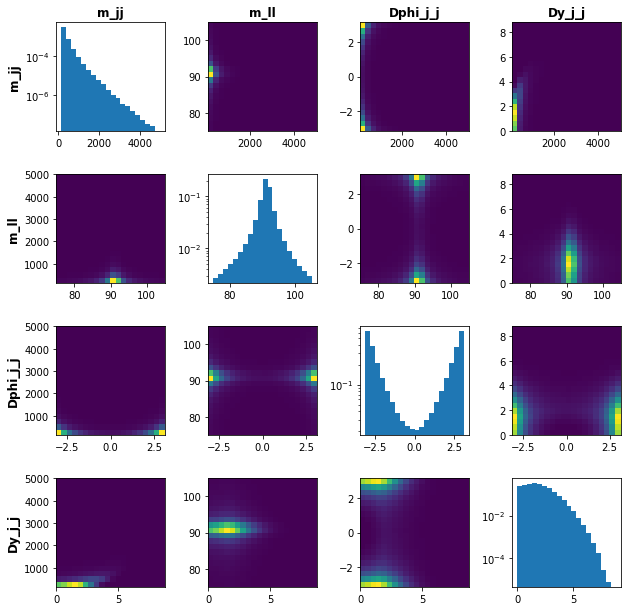

Filter efficiency is 100.000%


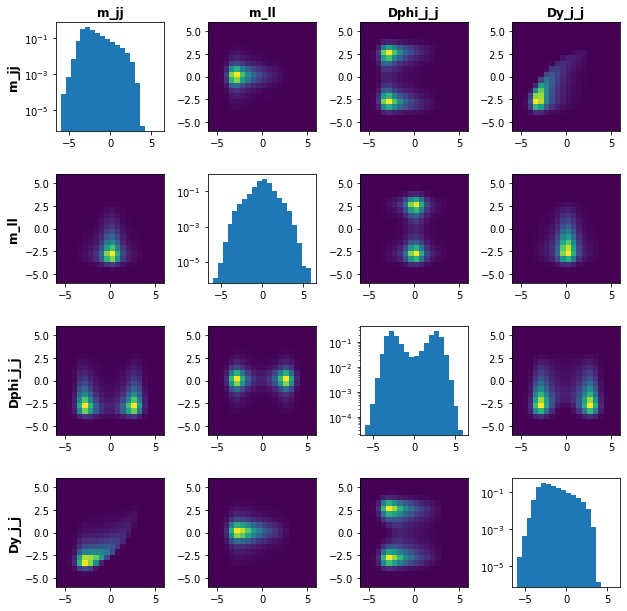

In [7]:

plot_data(observable_data  , weight_data   , keys=data.keys, bins=20, lims=True)
plot_data(white_data_to_fit, weights_to_fit, keys=data.keys, bins=20, lims=False)


In [8]:
#==================================
#===   LOAD / BUILD&FIT MODEL   ===
#==================================


#  Make sure eager execution is definitely off
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


#  Set the narrowness of the initial Gaussians (impacts postfit result)
density_model.Gauss_width_reduction_factor = 1.


#  Load model if requested, otherwise build and fit
#
if type(load_model_dir) != type(None) :
    density_model = DensityModel.from_dir(load_model_dir)
else :
    #
    #   Figure out the limits of the observables
    #
    range_limits = {}
    for idx in range(num_observables) :
        imin, imax = np.min(white_data_to_fit[:,idx]), np.max(white_data_to_fit[:,idx])
        irange     = imax - imin
        range_limits[idx] = [imin + 2.*irange/output_size_per_stage, imax - 2.*irange/output_size_per_stage] 
    #
    #   Create density model  
    #
    density_model = DensityModel(name             = "QCD_density_model", 
                                 num_gaussians    = output_size_per_stage, 
                                 num_conditions   = 1, 
                                 num_observables  = data.get_num_observables(), 
                                 types            = data.types,
                                 int_limits       = {idx:observable_limits[obs] for idx,(obs,t) in enumerate(zip(data.keys, data.types)) if t == int},
                                 verbose          = True,
                                 learning_rate    = learning_rate,
                                 optimiser        = optimiser,
                                 range_limits     = range_limits)
    #
    #   Fit density model
    #
    fit_times = {}
    for obs_idx in range(num_observables) :
        fit_start_time = time.time()
        num_epochs = 1
        density_model.fit({0:white_data_to_fit}, 
                          {0:weights_to_fit},
                          observable                = obs_idx,
                          max_epochs_per_observable = num_epochs,
                          early_stopping_patience   = early_stopping_patience,
                          early_stopping_min_delta  = early_stopping_min_delta,
                          validation_split          = validation_split,
                          batch_size_per_observable = batch_size)
        fit_times [obs_idx] = [num_epochs, time.time() - fit_start_time]


INFO       DensityModel.construct      Set model name           : QCD_density_model
INFO       DensityModel.construct      Set model num_gaussians  : 20
INFO       DensityModel.construct      Set model num_conditions : 1
INFO       DensityModel.construct      Set model num_observables: 4
INFO       DensityModel.construct      Set observable types     : [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
INFO       DensityModel.construct      Set kernel_initializer   : glorot_uniform
INFO       DensityModel.construct      Set bias_initializer     : zeros
INFO       DensityModel.build          Building model segment: QCD_density_model_observable0 for observable index 0
Creating continuous density model: QCD_density_model_observable0
  - num_conditions_in  is 1
  - num_observables_in is 0
  - num_gaussians      is 20
  - range              is -5.0346 - 2.6884
  - kernel_initializer is glorot_uniform
  - bias_initializer   is zeros
Model: "QCD_density_model_observable0"
__

Model: "QCD_density_model_observable2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 7)            14          input_4[0][0]                    
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 6)            18          input_5[0][0]                    
______________________________________________________________________

INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 1
INFO       DensityModel.fit              -  Training setting: batch_size = 5000
INFO       DensityModel.fit              -  Training setting: validation_split = 0.5
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 10
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 603090 samples, validate on 603091 samples
585000/603090 [============================>.] - ETA: 0s - loss: 1.7283e-06

W1011 22:31:26.454771 4545004992 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


603090/603090 [==============================] - 2s 4us/sample - loss: 1.7279e-06 - val_loss: 1.7127e-06
Fit completed in 5s
INFO       DensityModel.fit            Queued the following observable indices to train: 1
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 1
INFO       DensityModel.fit              -  Training setting: epochs = 1
INFO       DensityModel.fit              -  Training setting: batch_size = 5000
INFO       DensityModel.fit              -  Training setting: validation_split = 0.5
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 10
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 603090 samples, validate on 603091 samples
603090/603090 [==============================] - 2s 4us/sample - loss: 1.7835e-06 - val_loss: 1.6832e-06
Fit completed in 5s
INFO       DensityModel.fit            Queued the following

In [9]:
#  Use this cell to add training epochs to whichever indices appear undertrained

improve_indices   = [i for i in range(num_observables)]

added_fit_times = {}
for obs_idx in improve_indices :
    fit_start_time = time.time()
    num_epochs = max_epochs + obs_idx*epoch_increase_per_level
    density_model.fit({0:white_data_to_fit}, 
                      {0:weights_to_fit},
                      observable                = obs_idx,
                      max_epochs_per_observable = num_epochs,
                      early_stopping_patience   = early_stopping_patience,
                      early_stopping_min_delta  = early_stopping_min_delta,
                      validation_split          = validation_split,
                      batch_size_per_observable = batch_size)
    added_fit_times [obs_idx] = [num_epochs, time.time() - fit_start_time]
    

INFO       DensityModel.fit            Queued the following observable indices to train: 0
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 1000
INFO       DensityModel.fit              -  Training setting: batch_size = 5000
INFO       DensityModel.fit              -  Training setting: validation_split = 0.5
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 10
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 603090 samples, validate on 603091 samples
Epoch 1/1000
603090/603090 [==============================] - 2s 3us/sample - loss: 1.6947e-06 - val_loss: 1.6758e-06
Epoch 2/1000
603090/603090 [==============================] - 2s 3us/sample - loss: 1.6569e-06 - val_loss: 1.6380e-06
Epoch 3/1000
603090/603090 [==============================] - 2s 3us/s

603090/603090 [==============================] - 2s 4us/sample - loss: 1.2895e-06 - val_loss: 1.2906e-06
Epoch 65/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2895e-06 - val_loss: 1.2906e-06
Epoch 66/1000
603090/603090 [==============================] - 2s 3us/sample - loss: 1.2895e-06 - val_loss: 1.2906e-06
Epoch 67/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2895e-06 - val_loss: 1.2906e-06
Epoch 68/1000
603090/603090 [==============================] - 2s 3us/sample - loss: 1.2895e-06 - val_loss: 1.2906e-06
Epoch 69/1000
603090/603090 [==============================] - 2s 3us/sample - loss: 1.2895e-06 - val_loss: 1.2906e-06
Epoch 70/1000
603090/603090 [==============================] - 2s 3us/sample - loss: 1.2894e-06 - val_loss: 1.2906e-06
Epoch 71/1000
603090/603090 [==============================] - 2s 3us/sample - loss: 1.2894e-06 - val_loss: 1.2906e-06
Epoch 72/1000
603090/603090 [==============================] -

603090/603090 [==============================] - 2s 4us/sample - loss: 1.2894e-06 - val_loss: 1.2905e-06
Epoch 133/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2894e-06 - val_loss: 1.2905e-06
Epoch 134/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2894e-06 - val_loss: 1.2905e-06
Epoch 135/1000
603090/603090 [==============================] - 2s 3us/sample - loss: 1.2894e-06 - val_loss: 1.2905e-06
Epoch 136/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2894e-06 - val_loss: 1.2905e-06
Epoch 137/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2894e-06 - val_loss: 1.2905e-06
Epoch 138/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2894e-06 - val_loss: 1.2905e-06
Epoch 139/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2894e-06 - val_loss: 1.2905e-06
Epoch 140/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.2894e-06 - val_loss: 1.2905e-06
Epoch 201/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2894e-06 - val_loss: 1.2905e-06
Epoch 202/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2894e-06 - val_loss: 1.2905e-06
Epoch 203/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2894e-06 - val_loss: 1.2905e-06
Epoch 204/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2894e-06 - val_loss: 1.2905e-06
Epoch 205/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2894e-06 - val_loss: 1.2905e-06
Epoch 206/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2894e-06 - val_loss: 1.2905e-06
Epoch 207/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2894e-06 - val_loss: 1.2905e-06
Epoch 208/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2905e-06
Epoch 269/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2905e-06
Epoch 270/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2905e-06
Epoch 271/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2905e-06
Epoch 272/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2905e-06
Epoch 273/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2905e-06
Epoch 274/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2905e-06
Epoch 275/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2905e-06
Epoch 276/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2905e-06
Epoch 337/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2905e-06
Epoch 338/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2905e-06
Epoch 339/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2905e-06
Epoch 340/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2905e-06
Epoch 341/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2905e-06
Epoch 342/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2905e-06
Epoch 343/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2905e-06
Epoch 344/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 405/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 406/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 407/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 408/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 409/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 410/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 411/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 412/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 473/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 474/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 475/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 476/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 477/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 478/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 479/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 480/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 541/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 542/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 543/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 544/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 545/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 546/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 547/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 548/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 609/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 610/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 611/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 612/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 613/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 614/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 615/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 616/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 677/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 678/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 679/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 680/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 681/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 682/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 683/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2893e-06 - val_loss: 1.2904e-06
Epoch 684/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.2204e-06 - val_loss: 1.2159e-06
Epoch 13/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2135e-06 - val_loss: 1.2093e-06
Epoch 14/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2072e-06 - val_loss: 1.2033e-06
Epoch 15/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.2014e-06 - val_loss: 1.1978e-06
Epoch 16/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1963e-06 - val_loss: 1.1930e-06
Epoch 17/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1919e-06 - val_loss: 1.1889e-06
Epoch 18/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1881e-06 - val_loss: 1.1854e-06
Epoch 19/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1848e-06 - val_loss: 1.1823e-06
Epoch 20/1000
603090/603090 [==============================] -

Epoch 81/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1450e-06 - val_loss: 1.1442e-06
Epoch 82/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1449e-06 - val_loss: 1.1441e-06
Epoch 83/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1448e-06 - val_loss: 1.1440e-06
Epoch 84/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1447e-06 - val_loss: 1.1440e-06
Epoch 85/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1447e-06 - val_loss: 1.1438e-06
Epoch 86/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1446e-06 - val_loss: 1.1438e-06
Epoch 87/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1445e-06 - val_loss: 1.1437e-06
Epoch 88/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1444e-06 - val_loss: 1.1436e-06
Epoch 89/1000
603090/603090 [===================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.1418e-06 - val_loss: 1.1410e-06
Epoch 150/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1417e-06 - val_loss: 1.1410e-06
Epoch 151/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1417e-06 - val_loss: 1.1409e-06
Epoch 152/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1417e-06 - val_loss: 1.1409e-06
Epoch 153/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1417e-06 - val_loss: 1.1410e-06
Epoch 154/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1417e-06 - val_loss: 1.1409e-06
Epoch 155/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1416e-06 - val_loss: 1.1409e-06
Epoch 156/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1416e-06 - val_loss: 1.1408e-06
Epoch 157/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.1408e-06 - val_loss: 1.1401e-06
Epoch 218/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1408e-06 - val_loss: 1.1401e-06
Epoch 219/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1408e-06 - val_loss: 1.1400e-06
Epoch 220/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1408e-06 - val_loss: 1.1400e-06
Epoch 221/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1408e-06 - val_loss: 1.1400e-06
Epoch 222/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1408e-06 - val_loss: 1.1400e-06
Epoch 223/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1408e-06 - val_loss: 1.1400e-06
Epoch 224/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1408e-06 - val_loss: 1.1400e-06
Epoch 225/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.1404e-06 - val_loss: 1.1397e-06
Epoch 286/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1404e-06 - val_loss: 1.1397e-06
Epoch 287/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1404e-06 - val_loss: 1.1397e-06
Epoch 288/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1404e-06 - val_loss: 1.1397e-06
Epoch 289/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1404e-06 - val_loss: 1.1397e-06
Epoch 290/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1404e-06 - val_loss: 1.1397e-06
Epoch 291/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1404e-06 - val_loss: 1.1397e-06
Epoch 292/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1404e-06 - val_loss: 1.1397e-06
Epoch 293/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.1403e-06 - val_loss: 1.1396e-06
Epoch 354/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1403e-06 - val_loss: 1.1395e-06
Epoch 355/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1403e-06 - val_loss: 1.1395e-06
Epoch 356/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1403e-06 - val_loss: 1.1396e-06
Epoch 357/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1403e-06 - val_loss: 1.1396e-06
Epoch 358/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1403e-06 - val_loss: 1.1395e-06
Epoch 359/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1403e-06 - val_loss: 1.1395e-06
Epoch 360/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1403e-06 - val_loss: 1.1395e-06
Epoch 361/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.1402e-06 - val_loss: 1.1395e-06
Epoch 422/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1402e-06 - val_loss: 1.1395e-06
Epoch 423/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1402e-06 - val_loss: 1.1395e-06
Epoch 424/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1402e-06 - val_loss: 1.1395e-06
Epoch 425/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1402e-06 - val_loss: 1.1395e-06
Epoch 426/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1402e-06 - val_loss: 1.1395e-06
Epoch 427/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1402e-06 - val_loss: 1.1395e-06
Epoch 428/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1402e-06 - val_loss: 1.1395e-06
Epoch 429/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.1401e-06 - val_loss: 1.1394e-06
Epoch 490/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1401e-06 - val_loss: 1.1394e-06
Epoch 491/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1401e-06 - val_loss: 1.1394e-06
Epoch 492/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1401e-06 - val_loss: 1.1394e-06
Epoch 493/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1401e-06 - val_loss: 1.1394e-06
Epoch 494/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1401e-06 - val_loss: 1.1394e-06
Epoch 495/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1401e-06 - val_loss: 1.1394e-06
Epoch 496/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1401e-06 - val_loss: 1.1394e-06
Epoch 497/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.1323e-06 - val_loss: 1.1317e-06
Epoch 558/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1323e-06 - val_loss: 1.1317e-06
Epoch 559/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1323e-06 - val_loss: 1.1316e-06
Epoch 560/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1323e-06 - val_loss: 1.1316e-06
Epoch 561/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1323e-06 - val_loss: 1.1316e-06
Epoch 562/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1323e-06 - val_loss: 1.1316e-06
Epoch 563/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1322e-06 - val_loss: 1.1316e-06
Epoch 564/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1322e-06 - val_loss: 1.1316e-06
Epoch 565/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.1319e-06 - val_loss: 1.1313e-06
Epoch 626/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1319e-06 - val_loss: 1.1313e-06
Epoch 627/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1319e-06 - val_loss: 1.1313e-06
Epoch 628/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1319e-06 - val_loss: 1.1313e-06
Epoch 629/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1319e-06 - val_loss: 1.1313e-06
Epoch 630/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1319e-06 - val_loss: 1.1313e-06
Epoch 631/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1319e-06 - val_loss: 1.1313e-06
Epoch 632/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1319e-06 - val_loss: 1.1313e-06
Epoch 633/1000
603090/603090 [=========================

Epoch 50/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5218e-06 - val_loss: 1.5225e-06
Epoch 51/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5217e-06 - val_loss: 1.5224e-06
Epoch 52/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5215e-06 - val_loss: 1.5222e-06
Epoch 53/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5214e-06 - val_loss: 1.5221e-06
Epoch 54/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5212e-06 - val_loss: 1.5220e-06
Epoch 55/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5211e-06 - val_loss: 1.5219e-06
Epoch 56/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5210e-06 - val_loss: 1.5218e-06
Epoch 57/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5209e-06 - val_loss: 1.5217e-06
Epoch 58/1000
603090/603090 [===================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.5185e-06 - val_loss: 1.5193e-06
Epoch 119/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5184e-06 - val_loss: 1.5193e-06
Epoch 120/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5184e-06 - val_loss: 1.5193e-06
Epoch 121/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5184e-06 - val_loss: 1.5192e-06
Epoch 122/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5184e-06 - val_loss: 1.5192e-06
Epoch 123/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5184e-06 - val_loss: 1.5192e-06
Epoch 124/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5184e-06 - val_loss: 1.5192e-06
Epoch 125/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5184e-06 - val_loss: 1.5192e-06
Epoch 126/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.5179e-06 - val_loss: 1.5187e-06
Epoch 187/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5179e-06 - val_loss: 1.5187e-06
Epoch 188/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5179e-06 - val_loss: 1.5187e-06
Epoch 189/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5179e-06 - val_loss: 1.5187e-06
Epoch 190/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5179e-06 - val_loss: 1.5187e-06
Epoch 191/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5179e-06 - val_loss: 1.5187e-06
Epoch 192/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5179e-06 - val_loss: 1.5187e-06
Epoch 193/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5179e-06 - val_loss: 1.5187e-06
Epoch 194/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.5178e-06 - val_loss: 1.5186e-06
Epoch 255/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5178e-06 - val_loss: 1.5185e-06
Epoch 256/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5177e-06 - val_loss: 1.5185e-06
Epoch 257/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5177e-06 - val_loss: 1.5185e-06
Epoch 258/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5177e-06 - val_loss: 1.5185e-06
Epoch 259/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5177e-06 - val_loss: 1.5185e-06
Epoch 260/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5177e-06 - val_loss: 1.5185e-06
Epoch 261/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5177e-06 - val_loss: 1.5185e-06
Epoch 262/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.5177e-06 - val_loss: 1.5184e-06
Epoch 323/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5177e-06 - val_loss: 1.5184e-06
Epoch 324/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5177e-06 - val_loss: 1.5184e-06
Epoch 325/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5177e-06 - val_loss: 1.5185e-06
Epoch 326/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5177e-06 - val_loss: 1.5184e-06
Epoch 327/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5177e-06 - val_loss: 1.5184e-06
Epoch 328/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5176e-06 - val_loss: 1.5184e-06
Epoch 329/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5177e-06 - val_loss: 1.5184e-06
Epoch 330/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.5176e-06 - val_loss: 1.5184e-06
Epoch 391/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5176e-06 - val_loss: 1.5184e-06
Epoch 392/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5176e-06 - val_loss: 1.5184e-06
Epoch 393/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5176e-06 - val_loss: 1.5184e-06
Epoch 394/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5176e-06 - val_loss: 1.5184e-06
Epoch 395/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5176e-06 - val_loss: 1.5184e-06
Epoch 396/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5176e-06 - val_loss: 1.5184e-06
Epoch 397/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5176e-06 - val_loss: 1.5184e-06
Epoch 398/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.6420e-06 - val_loss: 1.5988e-06
Epoch 2/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.5608e-06 - val_loss: 1.5245e-06
Epoch 3/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.4927e-06 - val_loss: 1.4628e-06
Epoch 4/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.4372e-06 - val_loss: 1.4144e-06
Epoch 5/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.3955e-06 - val_loss: 1.3793e-06
Epoch 6/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.3656e-06 - val_loss: 1.3541e-06
Epoch 7/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.3439e-06 - val_loss: 1.3351e-06
Epoch 8/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.3271e-06 - val_loss: 1.3201e-06
Epoch 9/1000
603090/603090 [==============================] - 2s 4us/

603090/603090 [==============================] - 2s 4us/sample - loss: 1.1342e-06 - val_loss: 1.1341e-06
Epoch 71/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1338e-06 - val_loss: 1.1337e-06
Epoch 72/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1333e-06 - val_loss: 1.1332e-06
Epoch 73/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1329e-06 - val_loss: 1.1328e-06
Epoch 74/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1324e-06 - val_loss: 1.1324e-06
Epoch 75/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1320e-06 - val_loss: 1.1320e-06
Epoch 76/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1317e-06 - val_loss: 1.1316e-06
Epoch 77/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1313e-06 - val_loss: 1.1312e-06
Epoch 78/1000
603090/603090 [==============================] -

603090/603090 [==============================] - 2s 4us/sample - loss: 1.1167e-06 - val_loss: 1.1169e-06
Epoch 139/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1166e-06 - val_loss: 1.1168e-06
Epoch 140/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1165e-06 - val_loss: 1.1167e-06
Epoch 141/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1163e-06 - val_loss: 1.1166e-06
Epoch 142/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1162e-06 - val_loss: 1.1164e-06
Epoch 143/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1161e-06 - val_loss: 1.1163e-06
Epoch 144/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1160e-06 - val_loss: 1.1162e-06
Epoch 145/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1159e-06 - val_loss: 1.1161e-06
Epoch 146/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.1113e-06 - val_loss: 1.1115e-06
Epoch 207/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1113e-06 - val_loss: 1.1114e-06
Epoch 208/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1112e-06 - val_loss: 1.1115e-06
Epoch 209/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1112e-06 - val_loss: 1.1113e-06
Epoch 210/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1111e-06 - val_loss: 1.1113e-06
Epoch 211/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1110e-06 - val_loss: 1.1112e-06
Epoch 212/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1110e-06 - val_loss: 1.1112e-06
Epoch 213/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1110e-06 - val_loss: 1.1111e-06
Epoch 214/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.1086e-06 - val_loss: 1.1087e-06
Epoch 275/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1086e-06 - val_loss: 1.1087e-06
Epoch 276/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1085e-06 - val_loss: 1.1086e-06
Epoch 277/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1085e-06 - val_loss: 1.1086e-06
Epoch 278/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1085e-06 - val_loss: 1.1086e-06
Epoch 279/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1085e-06 - val_loss: 1.1085e-06
Epoch 280/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1084e-06 - val_loss: 1.1085e-06
Epoch 281/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1084e-06 - val_loss: 1.1085e-06
Epoch 282/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.1069e-06 - val_loss: 1.1070e-06
Epoch 343/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1069e-06 - val_loss: 1.1069e-06
Epoch 344/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1069e-06 - val_loss: 1.1070e-06
Epoch 345/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1069e-06 - val_loss: 1.1069e-06
Epoch 346/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1068e-06 - val_loss: 1.1069e-06
Epoch 347/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1068e-06 - val_loss: 1.1069e-06
Epoch 348/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1068e-06 - val_loss: 1.1068e-06
Epoch 349/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1068e-06 - val_loss: 1.1068e-06
Epoch 350/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.1057e-06 - val_loss: 1.1057e-06
Epoch 411/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1057e-06 - val_loss: 1.1057e-06
Epoch 412/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1057e-06 - val_loss: 1.1057e-06
Epoch 413/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1057e-06 - val_loss: 1.1057e-06
Epoch 414/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1057e-06 - val_loss: 1.1057e-06
Epoch 415/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1057e-06 - val_loss: 1.1056e-06
Epoch 416/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1056e-06 - val_loss: 1.1056e-06
Epoch 417/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1056e-06 - val_loss: 1.1056e-06
Epoch 418/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.1049e-06 - val_loss: 1.1049e-06
Epoch 479/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1049e-06 - val_loss: 1.1050e-06
Epoch 480/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1048e-06 - val_loss: 1.1048e-06
Epoch 481/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1048e-06 - val_loss: 1.1049e-06
Epoch 482/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1048e-06 - val_loss: 1.1048e-06
Epoch 483/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1048e-06 - val_loss: 1.1048e-06
Epoch 484/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1048e-06 - val_loss: 1.1047e-06
Epoch 485/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1048e-06 - val_loss: 1.1048e-06
Epoch 486/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.1041e-06 - val_loss: 1.1042e-06
Epoch 547/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1041e-06 - val_loss: 1.1040e-06
Epoch 548/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1041e-06 - val_loss: 1.1041e-06
Epoch 549/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1041e-06 - val_loss: 1.1041e-06
Epoch 550/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1040e-06 - val_loss: 1.1041e-06
Epoch 551/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1040e-06 - val_loss: 1.1040e-06
Epoch 552/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1040e-06 - val_loss: 1.1040e-06
Epoch 553/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1040e-06 - val_loss: 1.1040e-06
Epoch 554/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.1034e-06 - val_loss: 1.1034e-06
Epoch 615/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1034e-06 - val_loss: 1.1034e-06
Epoch 616/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1034e-06 - val_loss: 1.1034e-06
Epoch 617/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1034e-06 - val_loss: 1.1033e-06
Epoch 618/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1034e-06 - val_loss: 1.1035e-06
Epoch 619/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1034e-06 - val_loss: 1.1033e-06
Epoch 620/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1034e-06 - val_loss: 1.1033e-06
Epoch 621/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1033e-06 - val_loss: 1.1033e-06
Epoch 622/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.1029e-06 - val_loss: 1.1028e-06
Epoch 683/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1028e-06 - val_loss: 1.1029e-06
Epoch 684/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1029e-06 - val_loss: 1.1029e-06
Epoch 685/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1028e-06 - val_loss: 1.1029e-06
Epoch 686/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1028e-06 - val_loss: 1.1028e-06
Epoch 687/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1028e-06 - val_loss: 1.1028e-06
Epoch 688/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1028e-06 - val_loss: 1.1028e-06
Epoch 689/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1028e-06 - val_loss: 1.1028e-06
Epoch 690/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.1024e-06 - val_loss: 1.1024e-06
Epoch 751/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1024e-06 - val_loss: 1.1024e-06
Epoch 752/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1024e-06 - val_loss: 1.1024e-06
Epoch 753/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1024e-06 - val_loss: 1.1025e-06
Epoch 754/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1024e-06 - val_loss: 1.1024e-06
Epoch 755/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1024e-06 - val_loss: 1.1024e-06
Epoch 756/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1024e-06 - val_loss: 1.1024e-06
Epoch 757/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1024e-06 - val_loss: 1.1023e-06
Epoch 758/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.1020e-06 - val_loss: 1.1020e-06
Epoch 819/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1021e-06 - val_loss: 1.1020e-06
Epoch 820/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1020e-06 - val_loss: 1.1020e-06
Epoch 821/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1020e-06 - val_loss: 1.1020e-06
Epoch 822/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1020e-06 - val_loss: 1.1020e-06
Epoch 823/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1020e-06 - val_loss: 1.1020e-06
Epoch 824/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1020e-06 - val_loss: 1.1020e-06
Epoch 825/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1020e-06 - val_loss: 1.1020e-06
Epoch 826/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.1017e-06 - val_loss: 1.1018e-06
Epoch 887/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1017e-06 - val_loss: 1.1017e-06
Epoch 888/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1017e-06 - val_loss: 1.1017e-06
Epoch 889/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1017e-06 - val_loss: 1.1017e-06
Epoch 890/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1017e-06 - val_loss: 1.1017e-06
Epoch 891/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1017e-06 - val_loss: 1.1018e-06
Epoch 892/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1017e-06 - val_loss: 1.1016e-06
Epoch 893/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1017e-06 - val_loss: 1.1016e-06
Epoch 894/1000
603090/603090 [=========================

603090/603090 [==============================] - 2s 4us/sample - loss: 1.1014e-06 - val_loss: 1.1016e-06
Epoch 955/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1014e-06 - val_loss: 1.1014e-06
Epoch 956/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1014e-06 - val_loss: 1.1014e-06
Epoch 957/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1014e-06 - val_loss: 1.1014e-06
Epoch 958/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1014e-06 - val_loss: 1.1014e-06
Epoch 959/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1014e-06 - val_loss: 1.1014e-06
Epoch 960/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1014e-06 - val_loss: 1.1014e-06
Epoch 961/1000
603090/603090 [==============================] - 2s 4us/sample - loss: 1.1014e-06 - val_loss: 1.1014e-06
Epoch 962/1000
603090/603090 [=========================

In [10]:
'''
if type(save_model_dir) != type(None) :
    density_model.save_to_dir(".tmp_QCD_model_FridayMorning")'''

'\nif type(save_model_dir) != type(None) :\n    density_model.save_to_dir(".tmp_QCD_model_FridayMorning")'

In [11]:
#  Save model if requested

if type(save_model_dir) != type(None) :
    density_model.save_to_dir(save_model_dir)

In [22]:
#  Generate a large number of datapoints at 0.
#

n_gen = 2000000

print(f"Generating {n_gen} fake datapoints")
start = time.time()

fake_white_datapoints = density_model.sample(n_gen, [0])
end = time.time()
print(f"{n_gen} datapoints generated in {int(end-start):.0f}s")

#  Unwhiten generated data
#

print("Unwhitening fake datapoints for cWtil=0")
start = time.time()
fake_datapoints = unwhiten_axes(fake_white_datapoints, whitening_funcs)
end = time.time()
print(f"{n_gen} datapoints unwhitened in {int(end-start):.0f}s")


Generating 2000000 fake datapoints
INFO       DensityModel.sample         Sampling 2000000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 2000000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 2000000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 2000000 datapoints, observable index is 3
2000000 datapoints generated in 1148s
Unwhitening fake datapoints for cWtil=0
2000000 datapoints unwhitened in 57s


Filter efficiency is 100.000%


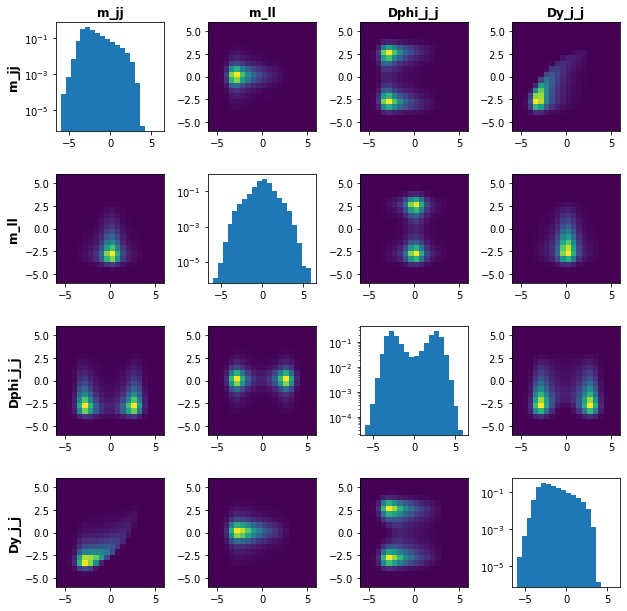

Filter efficiency is 100.000%


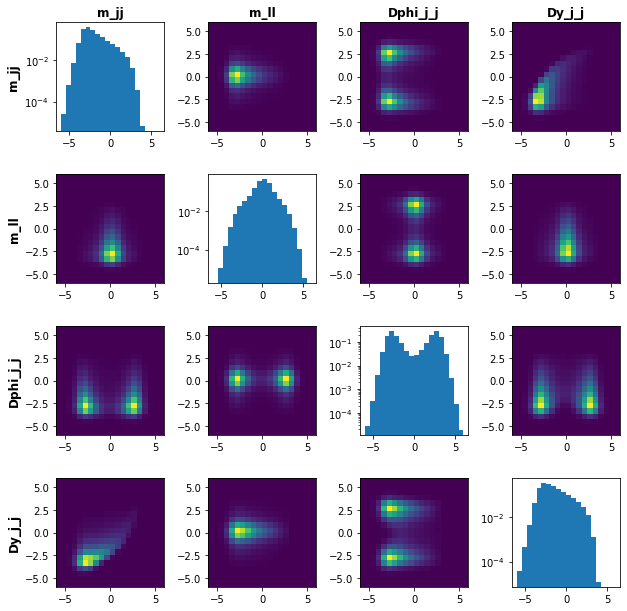

In [23]:
#  Plot original and generated data (total phase space)

plot_data(white_data_to_fit    , weights_to_fit, keys=data.keys, bins=20, lims=False)
plot_data(fake_white_datapoints, None          , keys=data.keys, bins=20, lims=False)


Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2 = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: divide by zero en

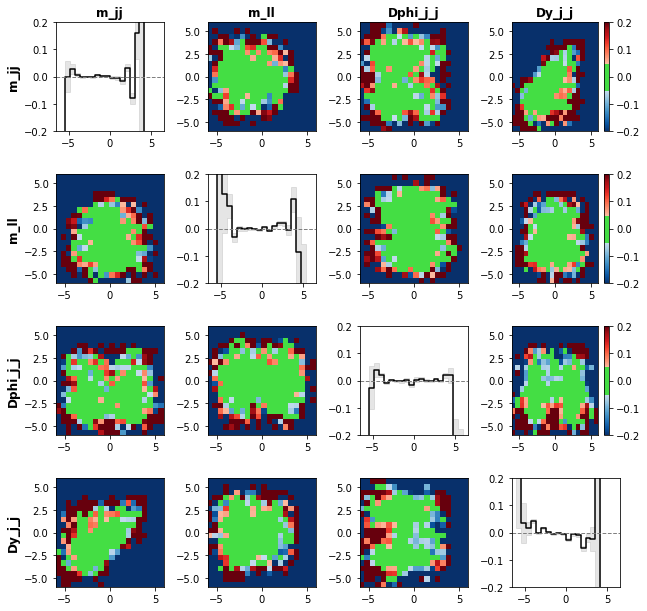

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: divide by zero encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2 = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: divide by zero encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: invalid value en

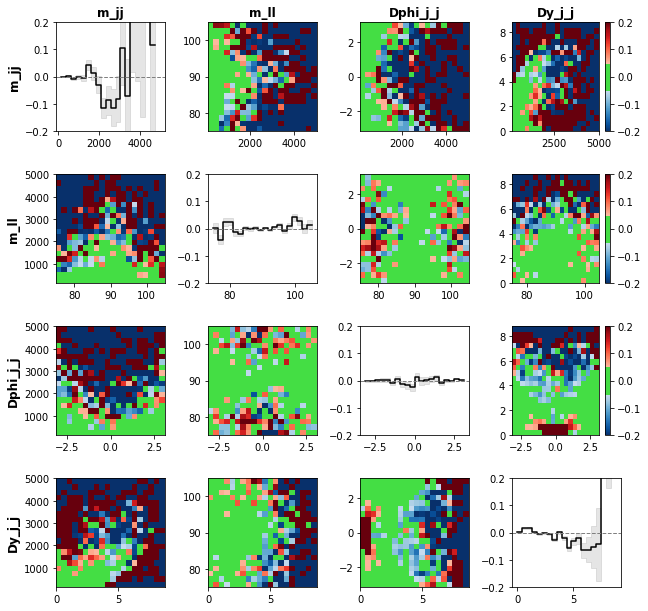

In [24]:
#  Plot ratio and pull between original and generated data (total phase space)

plot_ratio(white_data_to_fit, fake_white_datapoints, weights_to_fit, None, keys=data.keys, bins=20, lims=False)
plot_ratio(observable_data  , fake_datapoints      , weights_to_fit, None, keys=data.keys, bins=20)


In [25]:
#  Define VBF fiducial cuts
#
cuts = []
cuts.append(["m_jj"    , 1000, 5000])
cuts.append(["Dy_j_j"  , 2   , 8.8 ])

#  Plot the datapoints provided
#
def get_eff (data, weights=None, keys=[], cuts=[]) :
    if type(weights) == type(None) :
        weights = np.ones(shape=(data.shape[0],))
    filtered_data, filtered_weights = data, weights
    for cut in cuts :
        filtered_data, filtered_weights = filter_data (filtered_data, filtered_weights, keys, cut[0], cut[1], cut[2])
    return 100.*np.sum(filtered_weights)/np.sum(weights), 100.*np.sqrt(np.sum(filtered_weights*filtered_weights))/np.sum(weights)


In [26]:
#  Get a plot label for each observable
#

obs_labels = {}
obs_labels ["m_jj"    ] = r"$m_{jj}$  [TeV]"
obs_labels ["m_ll"    ] = r"$m_{ll}$  [GeV]"
obs_labels ["Dphi_j_j"] = r"$\Delta\phi\left(j,j\right)$"
obs_labels ["Dy_j_j"  ] = r"$\Delta y\left(j,j\right)$"

def get_obs_label (obs) :
    if obs in obs_labels :
        return obs_labels[obs]
    return obs


#  Plot the datapoints provided
#
def plot_observable_on_axis (ax, observable, data_num, data_den, weights_num=None, weights_den=None, keys=None, cuts=[], save="", lims=True, bins=20, label=None, normed=True, ebar=False) :
    if type(weights_num) == type(None) :
        weights_num = np.ones(shape=(data_num.shape[0],))
    if type(keys) == type(None) :
        keys = [f"obs{i}" for i in range(len(data_num))]
    filtered_data_num, filtered_weights_num = data_num, weights_num
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for numerator")
        filtered_data_num, filtered_weights_num = filter_data (filtered_data_num, filtered_weights_num, keys, cut[0], cut[1], cut[2])
    
    if type(weights_den) == type(None) :
        weights_den = np.ones(shape=(data_den.shape[0],))
    filtered_data_den, filtered_weights_den = data_den, weights_den
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for denominator")
        filtered_data_den, filtered_weights_den = filter_data (filtered_data_den, filtered_weights_den, keys, cut[0], cut[1], cut[2])
    
    obs_idx = keys.index(observable)
    if lims : obs_lims = observable_limits[observable]
    else    : obs_lims = [-5., 5.]
    if observable in int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 1+(obs_lims[1]-obs_lims[0]))
    else                             : bins = np.linspace(obs_lims[0], obs_lims[1], bins+1)
        
    data_x, data_z, data_ez = get_ratio_1D(filtered_data_den[:,obs_idx], filtered_data_num[:,obs_idx], bins, filtered_weights_den, filtered_weights_num, as_lines=True, normed=normed)
    data_z = np.nan_to_num(data_z)
    ax.plot(data_x, data_z-1., color="k", label=label)
    if ebar :ax.fill_between(data_x, data_z+data_ez-1, data_z-data_ez-1, alpha=0.3, color="grey")
    ax.set_xlim([bins[0], bins[-1]])
    
    ax.axhline(0    , linestyle="-" , c="grey", linewidth=2  )
    for h in [-0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4] :
        ax.axhline(h, linestyle="--", c="grey", linewidth=0.5)
        

/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: divide by zero encountered in true_divide
  ratio     = Z2 / Z1
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:2566: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: divide by zero encountered in true_divide
  ratio     = Z2 / Z1
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:2566: RuntimeWarning: overflow encountered in do

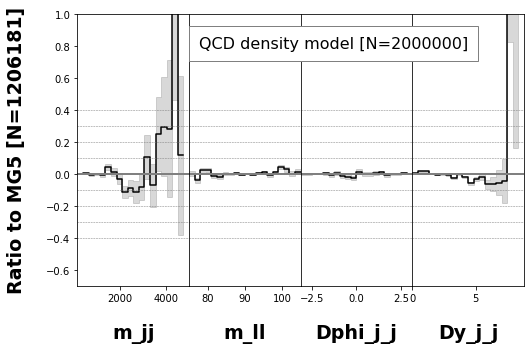

In [27]:

fig = plt.figure(figsize=(2*num_observables, 5))
for idx, obs in enumerate(observables_order) :
    ax = fig.add_subplot(1, num_observables, 1+idx)
    datapoints_true, weights_true = data.get_observables_and_weights()
    plot_observable_on_axis (ax, obs, fake_datapoints, datapoints_true, None, weights_true, keys=data.keys, bins=20, normed=True, ebar=True)
    ax.set_xlabel(obs, weight="bold", fontsize=19, labelpad=20)
    if idx == 0 :
        ax.set_ylabel(f"Ratio to MG5 [N={datapoints_true.shape[0]}]", fontsize=19, labelpad=20, weight="bold")
    else :
        ax.set_yticks([])
    if idx == num_observables-1 :
        ax.text(0.5, 0.92, f"QCD density model [N={fake_datapoints.shape[0]}]", fontsize=16, transform=ax.transAxes, ha="right", va="top", bbox=dict(facecolor='white', edgecolor='grey', pad=10.0))
    ax.set_ylim([-0.7, 1.])
plt.subplots_adjust(wspace=0)
plt.savefig(f"figures/QCD_ratio.pdf", bbox_inches="tight")
plt.show()


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:128: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


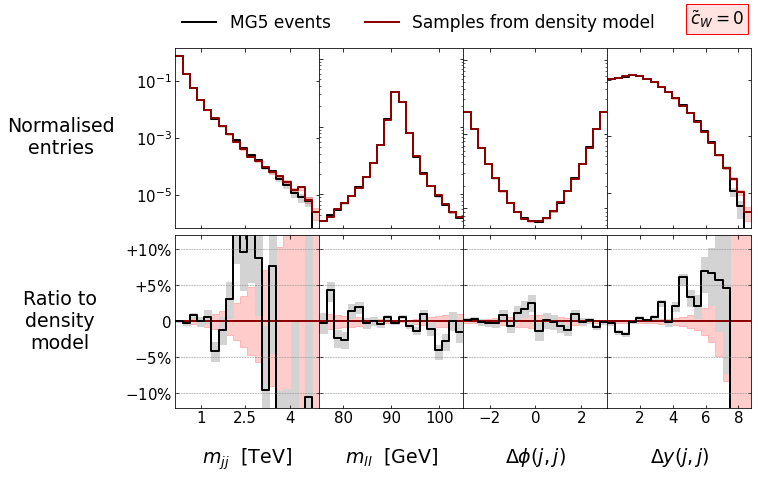

In [28]:

#  Data space distribution & ratio (c=0)
def histo_to_line (bins, values, errors) :
    X, Z, EZ = [], [], []
    for zp in values :
        Z .append(zp)
        Z .append(zp)
    for ezp in errors :
        EZ.append(ezp)
        EZ.append(ezp)
    for i in range(len(bins)-1) :
        X .append(bins[i])
        X .append(bins[i+1])
    return np.array(X), np.array(Z), np.array(EZ)


fig = plt.figure(figsize=(8, 5))

axes1, axes2 = [], []
ylos , yhis  = [], []

for obs_idx, observable in enumerate(observables_order) :
    
    #  Get axis x coordinates
    xlo    = obs_idx / num_observables
    xwidth = 1.      / num_observables
    
    #  ============
    #     AXIS 1
    #  ============

    ax1 = fig.add_axes([xlo, 0.50, xwidth, 0.5])
    
    datapoints_true, weights_true = data.get_observables_and_weights()
    
    obs_lims   = observable_limits[observable]
    num_bins   = 20
    if observable in int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 1+(obs_lims[1]-obs_lims[0]))
    else                             : bins = np.linspace(obs_lims[0], obs_lims[1], num_bins+1)
        
    hvals1, _ = np.histogram(datapoints_true       [:,obs_idx], bins=bins, weights=weights_true             )
    herrs1, _ = np.histogram(datapoints_true       [:,obs_idx], bins=bins, weights=weights_true*weights_true)
    herrs1    = np.sqrt(herrs1)
    hvals1, herrs1 = hvals1/np.sum(weights_true), herrs1/np.sum(weights_true)
    hvals2, _ = np.histogram(fake_datapoints[:,obs_idx], bins=bins)
    herrs2    = np.sqrt(hvals2)
    hvals2, herrs2 = hvals2/len(fake_datapoints), herrs2/len(fake_datapoints)
    
    plot_x, plot_y1, plot_ey1 = histo_to_line(bins, hvals1, herrs1)
    _     , plot_y2, plot_ey2 = histo_to_line(bins, hvals2, herrs2)
    
    ax1.plot(plot_x, plot_y1, "-", color="k"      , linewidth=2, label="MG5 events")
    ax1.fill_between(plot_x, plot_y1-plot_ey1, plot_y1+plot_ey1, color="lightgrey", alpha=1)
    ax1.plot(plot_x, plot_y2, "-", color="darkred", linewidth=2, label="Samples from density model")
    ax1.fill_between(plot_x, plot_y2-plot_ey2, plot_y2+plot_ey2, color="red", alpha=0.2)
    ax1.set_yscale("log")
    
    # Save y values range
    ylo, yhi = np.min([plot_y1-plot_ey1, plot_y2-plot_ey2]), np.max([plot_y1+plot_ey1, plot_y2+plot_ey2])
    ylos.append(ylo)
    yhis.append(yhi)
        
    
    #  ============
    #     AXIS 2
    #  ============

    ax2 = fig.add_axes([xlo, 0, xwidth, 0.48])
    
    ax2.axhline(0, c="darkred", linewidth=2)
    ax2.fill_between(plot_x, -plot_ey2/plot_y2, plot_ey2/plot_y2, color="red", alpha=0.2)
    ax2.plot(plot_x, (plot_y1-plot_y2)/plot_y2, c="k", linewidth=2)
    ax2.fill_between(plot_x, (plot_y1-plot_ey1-plot_y2)/plot_y1, (plot_y1+plot_ey1-plot_y2)/plot_y1, color="lightgrey", alpha=1)
    ax2.set_ylim([-0.12, 0.12])
    
    for h in [-0.1, -0.05, 0.05, 0.1] :
        ax2.axhline(h, linestyle="--", c="grey", linewidth=0.5)
    
    #  Set y axis tick labels    
    if obs_idx > 0 :
        ax1.get_yaxis().set_ticklabels([])
        ax2.get_yaxis().set_ticklabels([])
        
    #  Set x axis tick labels
    ax1.get_xaxis().set_ticklabels([])
    if obs_idx == 0 : 
        ax1.set_xticks([1000, 2500, 4000])
        ax2.set_xticks([1000, 2500, 4000])
        ax2.get_xaxis().set_ticklabels(["1" , "2.5", "4" ])
    if obs_idx == 1 : 
        ax1.set_xticks([80, 90, 100])
        ax2.set_xticks([80, 90, 100])
    if obs_idx == 2 : 
        ax1.set_xticks([-2, 0, 2])
        ax2.set_xticks([-2, 0, 2])
    if obs_idx == 3 : 
        ax1.set_xticks([2, 4, 6, 8])
        ax2.set_xticks([2, 4, 6, 8])
        
    #  Set x axis labels
    ax2.set_xlabel(get_obs_label(observable), fontsize=19, labelpad=20)
        
    #  Set y axis labels
    if obs_idx == 0 : 
        ax1.set_ylabel("Normalised\nentries", fontsize=19, labelpad=75, rotation=0, va="center")
        ax2.set_ylabel("Ratio to\ndensity\nmodel", fontsize=19, labelpad=65, rotation=0, va="center")
        ax1.legend(loc=(0, 1.05), frameon=True, edgecolor="white", facecolor="white", ncol=2, fontsize=17)
      
    #  Draw cWtil label
    if obs_idx == (num_observables-1) : 
        ax1.text(0.95, 1.1, r"${\tilde c}_W=0$", fontsize=17, transform=ax1.transAxes, ha="right", va="bottom", bbox=dict(facecolor='mistyrose', edgecolor='red', pad=4.0))
    
    #  Set x limits
    ax1.set_xlim([bins[0], bins[-1]])
    ax2.set_xlim([bins[0], bins[-1]])
    
    #  Set tick params
    ax1.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)
    ax2.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)
    
    #  Save axes
    axes1.append(ax1)
    axes2.append(ax2)

        
#  Set consistent axis y lims
for ax in axes1 :
    ax.set_ylim([np.min(ylos)/2., 2.*np.max(yhis)])

'''axes1[0].set_yticks     ([1, 0.1, 0.01, 0.001])
axes1[0].set_yticklabels([r"$100\%$", r"$10\%$", r"$1\%$", r"$0.1\%$"])'''

axes2[0].set_yticks     ([-0.1, -0.05, 0, 0.05, 0.1])
axes2[0].set_yticklabels([r"$-10\%$", r"$-5\%$", r"$0$", r"$+5\%$", r"$+10\%$"])
 
plt.savefig(f"figures/whitening_method/1D_distributions_QCD_density_model.pdf", bbox_inches="tight")
plt.show()


In [29]:
def plot_data_adv (datapoints, weights=None, label="", savefig="") :
    
    #  If no weights provided then assume uniform
    if type(weights) == type(None) :
        weights = np.ones(shape=(datapoints.shape[0],))
    
    #  Get histo bins
    get_bins = {}
    for obs_idx_x, obs_x in enumerate(observables_order) :
        obs_lims_x = observable_limits[obs_x]
        num_bins_x = 20
        if obs_x in int_observables : get_bins[obs_idx_x] = np.linspace(obs_lims_x[0]-0.5, obs_lims_x[1]+0.5, 1+(obs_lims_x[1]-obs_lims_x[0]))
        else                        : get_bins[obs_idx_x] = np.linspace(obs_lims_x[0], obs_lims_x[1], num_bins_x+1)

    #  First figure out our colour axis limits
    #     whilst we're at it, save the list of indices to plot (to make sure all loops are over consistent sets)
    vmin = 1e30
    observables_for_x, observables_for_y = [], []
    for obs_idx_x, obs_x in enumerate(observables_order) :
        #  Don't plot observable -1 on x axis
        if obs_idx_x == num_observables-1 : continue
        observables_for_x.append(obs_idx_x)
        for obs_idx_y, obs_y in enumerate(observables_order) :
            #  Don't plot observable 0 or above diagonal on y axis
            if obs_idx_y == 0         : continue
            if obs_idx_y <= obs_idx_x : continue
            observables_for_y.append(obs_idx_y)
            #  Get histo limits
            bins_x, bins_y = get_bins[obs_idx_x], get_bins[obs_idx_y]
            vals, _, _ = np.histogram2d(datapoints[:,obs_idx_x], datapoints[:,obs_idx_y], weights=weights, bins=(bins_x, bins_y))
            vals = vals.flatten()
            vals_min, vals_max = np.nanmin([v for v in vals if v > 0]), np.nanmax([v for v in vals if v > 0])
            vmin = np.nanmin([vmin, vals_min/vals_max])

    #  Make plot
    fig = plt.figure(figsize=(8, 5))
    vmin = 1e-5

    for obs_idx_x, obs_x in enumerate(observables_order) :

        #  Check whether we want to plot observable x
        if obs_idx_x not in observables_for_x : continue

        #  Get axis x coordinates
        xlo    = obs_idx_x / (num_observables-1)
        xwidth = 1.        / (num_observables-1)

        for obs_idx_y, obs_y in enumerate(observables_order) :

            #  Check whether we want to plot observable y
            if obs_idx_y not in observables_for_y : continue
            if obs_idx_y <= obs_idx_x : continue

            #  Get axis y coordinates
            ylo     = (num_observables-obs_idx_y-1) / (num_observables-1)
            yheight = 1.                            / (num_observables-1)

            #  Create axis
            ax = fig.add_axes([xlo, ylo, 0.95*xwidth, 0.95*yheight])

            #  Decide whether to draw axis labels
            if obs_idx_x != 0 : ax.get_yaxis().set_ticklabels([])
            else : 
                ax.set_ylabel(get_obs_label(obs_y), fontsize=19, labelpad=20)
            if obs_idx_y != num_observables-1 : ax.get_xaxis().set_ticklabels([])
            else : 
                ax.set_xlabel(get_obs_label(obs_x), fontsize=19, labelpad=20)
            
            if (obs_idx_x == 0) and (obs_idx_y == num_observables-1) : ax.get_xaxis().set_ticklabels(["1" , "2.5", "4" ])
            if (obs_idx_x == 0) and (obs_idx_y == 0) : ax.get_yaxis().set_ticklabels(["1" , "2.5", "4" ])
            if obs_idx_x == 0 : ax.set_xticks([1000, 2500, 4000])
            if obs_idx_x == 1 : ax.set_xticks([80, 90, 100])
            if obs_idx_x == 2 : ax.set_xticks([-2, 0, 2])
            if obs_idx_x == 3 : ax.set_xticks([2, 4, 6, 8])
        
            #  Format tick params
            ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)

            #  Draw histogram
            bins_x, bins_y = get_bins[obs_idx_x], get_bins[obs_idx_y]
            _, _, _, patches = ax.hist2d(datapoints[:,obs_idx_x], datapoints[:,obs_idx_y], weights=weights/vals_max, bins=(bins_x, bins_y),
                                         norm=colors.LogNorm(vmin=vmin, vmax=1))
            
            if (obs_idx_x==0) and (obs_idx_y==1) and len(label) > 0 :
                ax.text(0, 1.2, r"${\tilde c}_W=0$", fontsize=21, transform=ax.transAxes, ha="left", va="bottom", bbox=dict(facecolor='mistyrose', edgecolor='red', pad=4.0))
                ax.text(0.5, 1.2, label, weight="bold", ha="left", va="bottom", transform=ax.transAxes, fontsize=21)
                

    cbar_ax = fig.add_axes([0.76, 0.5, 0.03, 0.45])
    cbar    = fig.colorbar(patches, cax=cbar_ax)
    cbar_ax.tick_params(labelsize=14)
    cbar   .set_ticks([1, 0.1, 0.01, 0.001, 0.0001, 1e-5])
    cbar   .set_label(r"$\frac{p(x)}{{\rm max}~p(x)}$", fontsize=25, labelpad=50, rotation=0, va="center")

    if len(savefig) > 0 :
        plt.savefig(savefig, bbox_inches="tight")
    plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator


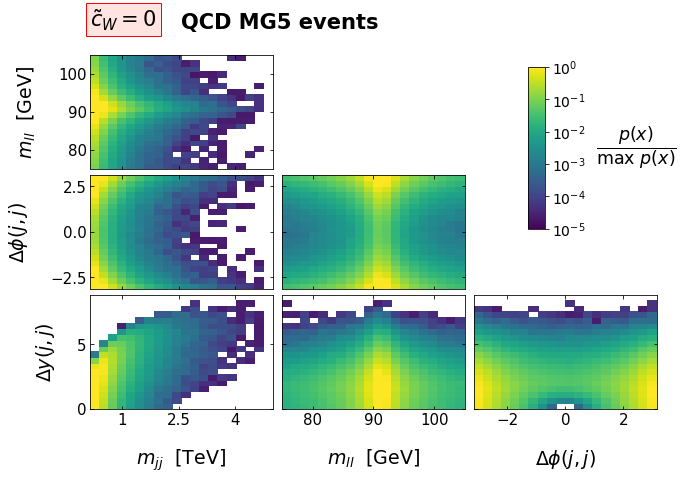

In [30]:

#  Plot MG5 events
datapoints_true, weights_true = data.get_observables_and_weights()
plot_data_adv(datapoints_true, weights_true, label="QCD MG5 events", savefig=f"figures/whitening_method/2D_distributions_QCD_MG5.pdf")


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator


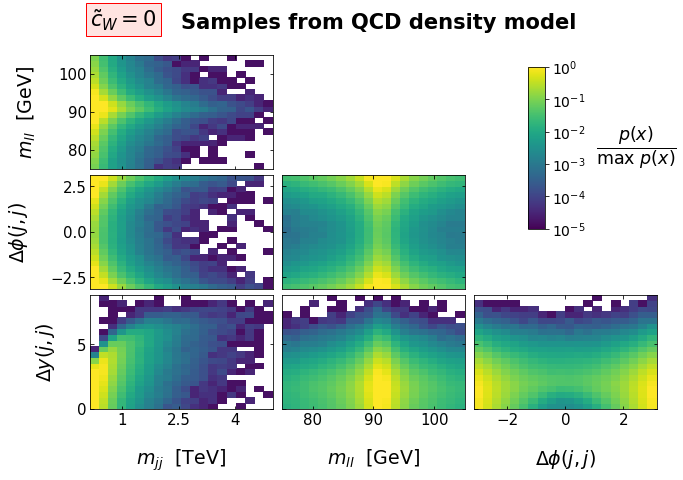

In [31]:

#  Plot generated events
plot_data_adv(fake_datapoints, label="Samples from QCD density model", savefig=f"figures/whitening_method/2D_distributions_QCD_density_model.pdf")
